<a href="https://colab.research.google.com/github/Charlwang922/Machine-Learning/blob/main/hw/hw4/ML-hw4-q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 Kernelized SVM vs Neural Networks: Theory and Empirics

Comparing Empirical Performance of KSVMs and NNs: If both KSVMs and NNs have universal approximation (as seen in previous parts), then why are NNs more used in practice?

While both KSVMs and NNs are powerful models that can work well on arbitrarily complex datasets, on simpler datasets, we want models that require fewer training samples to yield good prediction. Here we will compare the relative performance of KSVMs and NNs on increasingly complex datasets and study which model class adapts better.

Download the dataset provided. It contains train and test samples of various sizes of (x, y) pairs of functions with increasing complexity. For this question, you may use any library you want.


### (i) To get a feel for the data, create scatter plots (x vs. y) using 50 training samples and 1000 training samples for each function complexity. (There are a total of 10 plots.)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

In [2]:
#root = '/Users/charlottewang/Documents/GitHub/Machine-Learning/hw/hw4/ksvm_nn_data'
!unzip ksvm_nn_data.zip
root='/content/ksvm_nn_data'
folder = os.listdir(root)
file_paths=[]
train=[[]]*5
test=[[]]*5
for f in folder:
    if f.startswith('complexity'):
        file_paths.append(root+'/'+f)
for p in file_paths:
    files = os.listdir(p)
    for f in files:
        if f.endswith('train.csv'):
            #globals()['train_%s' % p[-1]] = pd.read_csv(p+'/'+f)
            train[int(p[-1])] = pd.read_csv(p+'/'+f)
        elif f.endswith('test.csv'):
            #globals()['test_%s' % p[-1]] = pd.read_csv(p+'/'+f)
            test[int(p[-1])] = pd.read_csv(p+'/'+f)


Archive:  ksvm_nn_data.zip
   creating: ksvm_nn_data/
  inflating: __MACOSX/._ksvm_nn_data  
  inflating: ksvm_nn_data/.DS_Store  
  inflating: __MACOSX/ksvm_nn_data/._.DS_Store  
   creating: ksvm_nn_data/complexity1/
  inflating: __MACOSX/ksvm_nn_data/._complexity1  
   creating: ksvm_nn_data/complexity0/
  inflating: __MACOSX/ksvm_nn_data/._complexity0  
   creating: ksvm_nn_data/complexity2/
  inflating: __MACOSX/ksvm_nn_data/._complexity2  
   creating: ksvm_nn_data/complexity3/
  inflating: __MACOSX/ksvm_nn_data/._complexity3  
   creating: ksvm_nn_data/complexity4/
  inflating: __MACOSX/ksvm_nn_data/._complexity4  
  inflating: ksvm_nn_data/complexity1/test.csv  
  inflating: __MACOSX/ksvm_nn_data/complexity1/._test.csv  
  inflating: ksvm_nn_data/complexity1/train.csv  
  inflating: __MACOSX/ksvm_nn_data/complexity1/._train.csv  
  inflating: ksvm_nn_data/complexity0/test.csv  
  inflating: __MACOSX/ksvm_nn_data/complexity0/._test.csv  
  inflating: ksvm_nn_data/complexity0/tra

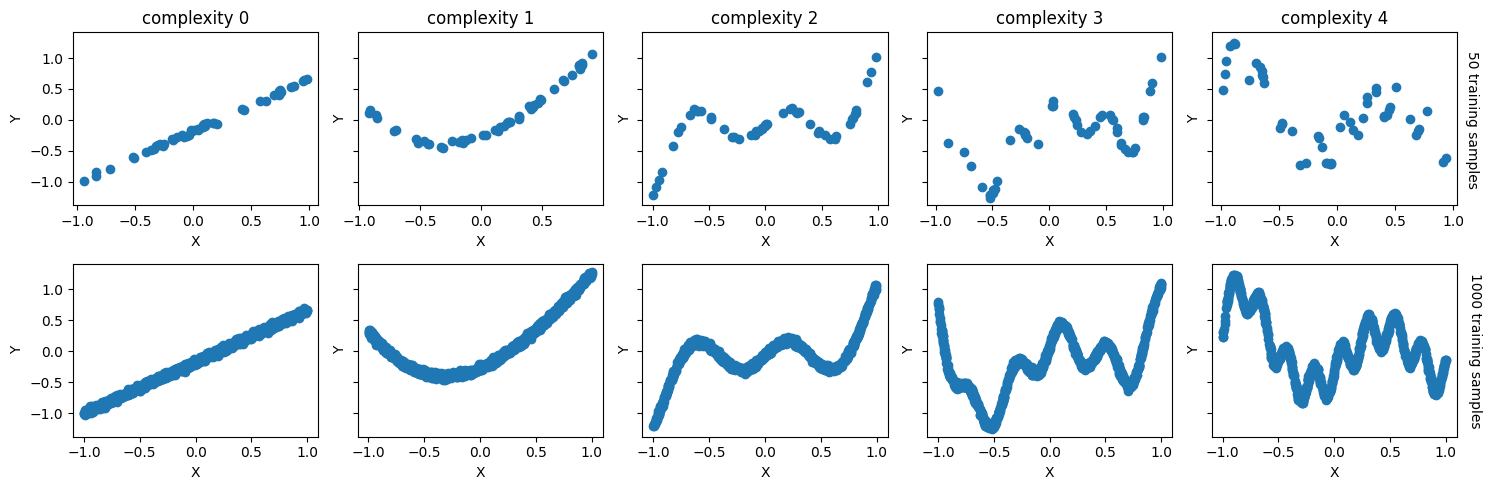

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5), sharey=True)

for i in range(5):
    axes[0,i].scatter(train[i]['x'][:50], train[i]['y'][:50])
    axes[0,i].set_xlabel('X')
    axes[0,i].set_ylabel('Y')
    axes[0,i].set_title(f'complexity {i}')
    if i == 4:
        axes[0,i].text(1.1,0,'50 training samples',verticalalignment='center',rotation=270) 
for i in range(5):
    axes[1,i].scatter(train[i]['x'][:1000], train[i]['y'][:1000])
    axes[1,i].set_xlabel('X')
    axes[1,i].set_ylabel('Y')
    if i == 4:
        axes[1,i].text(1.2,0,'1000 training samples',verticalalignment='center',rotation=270) 
plt.tight_layout()
plt.show()

(j) Train an RBF KSVM regressor and a NN for each function complexity with varying number of training samples.
Suggestions: 

For the SVM, it is advised you use SciKitLearn’s the built in Support Vector Regression function. The default settings should work fine, just ensure that you specify the right kernel. 

For the NN, it is advised you use PyTorch. Using a small neural network with 2 or 3 hidden layers and a dozen or a few dozen neurons per layer with the Adam optimizer and ReLU activation function should work well. To squeeze out good performance, try changing the number of epochs and the batch size first. Additionally, see this reference for more training tips: http://karpathy.github.io/2019/04/25/recipe/. You must use the MSE loss. 

For training sample sizes, consider sizes 50, 100, 300, 500, 750, and 1000.

In [5]:
#RBF KSVM
svr = svm.SVR(kernel='rbf')
training_size = [50, 100, 300, 500, 750, 1000]
mse_svm = np.zeros(shape=(5, len(training_size)))

for i in range(5):
    for b in range(len(training_size)):
        train_x = np.array(train[i]['x']).reshape(-1,1)[:training_size[b]]
        train_y = np.array(train[i]['y'])[:training_size[b]]
        test_x = np.array(test[i]['x']).reshape(-1,1)
        test_y = np.array(test[i]['y'])
        svr.fit(train_x, train_y)
        pred_y = svr.predict(test_x)
        mse_svm[i][b]= mean_squared_error(test_y,pred_y)

In [54]:
#Neural Network
class RegressionNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

#return mse
def train_nn(train, test, size, epochs):
  train_x = train.iloc[:size, 0].values.reshape(-1, 1)
  test_x = test.iloc[:, 0].values.reshape(-1, 1)
  scaler = StandardScaler()
  train_x = scaler.fit_transform(train_x)
  test_x = scaler.transform(test_x)
  train_y = train.iloc[:size, 1]
  test_y = test.iloc[:, 1]

  x_train_tensor = torch.tensor(train_x, dtype=torch.float)
  y_train_tensor = torch.tensor(train_y.values, dtype=torch.float).view(-1, 1)
  x_test_tensor = torch.tensor(test_x, dtype=torch.float)
  y_test_tensor = torch.tensor(test_y.values, dtype=torch.float).view(-1, 1)

  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  
  input_size = train_x.shape[1]
  hidden_size = 16
  output_size = 1
  model = RegressionNN(input_size, hidden_size, output_size)

  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  for epoch in range(epochs):
      for batch_X, batch_y in train_loader:
          optimizer.zero_grad()
          output = model(batch_X)
          loss = loss_fn(output, batch_y)
          loss.backward()
          optimizer.step()
  #perform on test data 
  test_pred = model(x_test_tensor)
  mse = loss_fn(y_test_tensor, test_pred).item()
  return mse


In [55]:
print(train_nn(train[0],test[0], 1000, 100))

0.0006645190878771245


In [ ]:
mse_nn_100 = mse_nn_1000 = np.zeros(shape=(5, len(training_size)))
for i in range(5):
  for j in range(len(training_size)):
    mse_nn_100[i][j] = train_nn(train[i],test[i], training_size[j], 100)
    mse_nn_1000[i][j] = train_nn(train[i],test[i], training_size[j], 1000)

### (k) For both KSVM and NN predictors, and each function complexity, plot the test MSE error for varying training sizes.

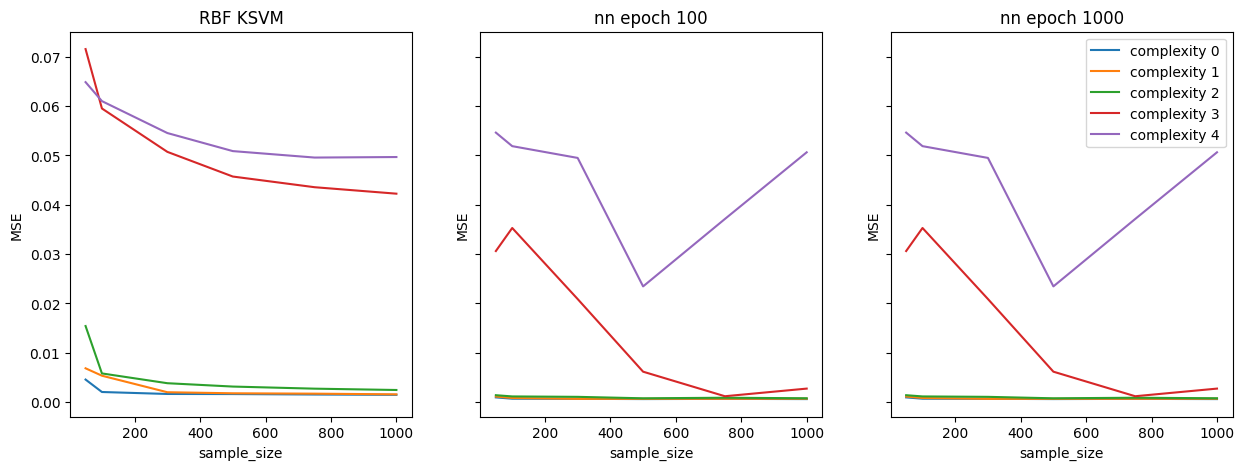

In [70]:
fig, axes = plt.subplots(1,3, figsize=(15, 5), sharey=True)
for i in range(5):
    axes[0].plot(training_size, mse_svm[i],label=f'complexity {i}')
    axes[1].plot(training_size, mse_nn_100[i],label=f'complexity {i}')
    axes[2].plot(training_size, mse_nn_1000[i],label=f'complexity {i}')
axes[0].set_xlabel('sample_size')
axes[0].set_ylabel('MSE')
axes[0].set_title('RBF KSVM')
axes[1].set_xlabel('sample_size')
axes[1].set_ylabel('MSE')
axes[1].set_title('nn epoch 100')
axes[2].set_xlabel('sample_size')
axes[2].set_ylabel('MSE')
axes[2].set_title('nn epoch 1000')
plt.legend()
plt.show()

In [ ]:
fig, axes =plt.subplots(1, 5, figsize=(15, 5), sharey=True)
for i in range(5):
    axes[i].plot(training_size, mse_svm[i],label='svm')
    axes[i].plot(training_size, mse_nn_100[i],label='nn epoch 100')
    axes[i].plot(training_size, mse_nn_1000[i],label='nn epoch 1000')
    axes[i].set_title(f'complexity {i}')
    axes[i].set_xlabel('sample_size')
    axes[i].set_ylabel('MSE')
plt.legend()
plt.show()